<h2> Рынок заведений общественного питания Москвы <a class="tocSkip"> </h2>
 

Цель проекта: исследовать рынок заведений общественного питания города Москвы для определения наиболее выгодного места для инвестирования. 

Исследуемые данные: датасет с заведениями общественного питания Москвы, составленный на основе данных сервисов Яндекс Карты и Яндекс Бизнес на лето 2022 года. Информация, размещённая в сервисе Яндекс Бизнес, могла быть добавлена пользователями или найдена в общедоступных источниках.

Проект состоит из двух частей:
    
 1. Исследование заведений общественного питания по округам Москвы, определение среднего рейтинга и изучение среднего чека.
 2. Исследование кофеин Москвы, определение среднего чека и рейтинга в зависимости от района. 

# Предобработка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px 
import folium
import json 
from folium import Map, Choropleth

In [2]:
df = pd.read_csv('/Users/alena/Desktop/ЯП/jupyter notebook/msc_places/moscow_places.csv')

In [3]:
# создаем функцию для получения общей информации 
def description(x):
    print('\033[1m' + 'Получение общей информации о данных в таблице:' + '\033[0m')
    display(x.info())
    print('\033[1m' + 'Наличие дубликатов в таблице:' + '\033[0m')
    display(x.duplicated().sum())   

In [4]:
description(df)

Получение общей информации о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


None

Наличие дубликатов в таблице:


0

Всего в датасете представлено 8406 строк с названиями заведений и среди них нет явных дубликтатов. Познакомимся с данными поближе

In [5]:
df['name'].value_counts()

name
Кафе                189
Шоколадница         120
Домино'с Пицца       76
Додо Пицца           74
One Price Coffee     71
                   ... 
Сащя                  1
Мой дом               1
Stardogs              1
Bar Park 15           1
Kebab Time            1
Name: count, Length: 5614, dtype: int64

In [6]:
len(list(df['name'].sort_values().unique())) # вывожу названия заведений

5614

In [7]:
df['name'] = df['name'].str.lower() # привожу к нижнему регистру
df['name'] = df['name'].str.strip() # удаляю пробелы
df['name'] = df['name'].str.replace('ё', 'е') # заменяю ё на е

df['address'] = df['address'].str.lower() 
df['address'] = df['address'].str.strip()
df['address'] = df['address'].str.replace('ё', 'е')

In [8]:
len(list(df['name'].sort_values().unique())) 

5506

In [9]:
df['name'].value_counts().head(20)

name
кафе                                   189
шоколадница                            120
домино'с пицца                          77
додо пицца                              74
one price coffee                        72
яндекс лавка                            69
cofix                                   65
prime                                   50
хинкальная                              44
шаурма                                  43
кофепорт                                42
кулинарная лавка братьев караваевых     39
теремок                                 38
чайхана                                 37
ресторан                                34
cofefest                                32
буханка                                 32
столовая                                28
му-му                                   27
drive café                              24
Name: count, dtype: int64

При приведении названий к нижнему регистру мы избавились от 118 неявнных дубликатов. В датасете представлено 5506 уникальных заведений Москвы.

In [10]:
df.isna().sum()

name                    0
category                0
address                 0
district                0
hours                 536
lat                     0
lng                     0
rating                  0
price                5091
avg_bill             4590
middle_avg_bill      5257
middle_coffee_cup    7871
chain                   0
seats                3611
dtype: int64

In [11]:
# определяю процент пропущенных значений в столбцах
pd.DataFrame(round(df.isna().mean()*100, 2))

,0
name,0.00
category,0.00
address,0.00
district,0.00
hours,6.38
lat,0.00
lng,0.00
rating,0.00
price,60.56
avg_bill,54.60


Присутсвуют пропуски в некоторых столбцах, большое количество пропусков в стобцах с категорией цен в заведении, в столбцах со средний чеком в заведении и, соответсвенно, в столбцах с оценкой среднего чека (middle_avg_bill) и с оценкой одной чашки капучино (middle_coffee_cup), потому что они расчитываются только для столбцов с указанным средним чеком. Заполнить пропуски со средним чеком не получится, оставим как есть. Также есть пропуски с количеством посадочных мест. 

In [12]:
df['street'] = df['address'].str.split(', ').str[1] 
# добавляю столбец с названием улиц методом сплитования, разделяя строку на части и выбирая вторую часть, где указано название улицы

In [13]:
df['is_247'] = df['hours'] == "ежедневно, круглосуточно" 
# с помощью логической индексации нахожу заведения, которые работают ежедневно и круглосуточно
df['is_247'].value_counts()

is_247
False    7676
True      730
Name: count, dtype: int64

Логическая индексация заменит пропуски на False, чтобы пропуски остались, необходимо применить метод contains 

In [14]:
df['is_247'] = df['hours'].str.contains('ежедневно, круглосуточно')
df['is_247'].value_counts()

is_247
False    7140
True      730
Name: count, dtype: int64

In [15]:
# заменю булевы переменные на 0 и 1
df['is_247'] = df['is_247'].apply(lambda x: 1 if x == True else 0)

In [16]:
# заменю 0 и 1 на более понятные термины
df['chain'] = df['chain'].apply(lambda x: 'сеть' if x == 1 else 'не сеть') 

In [17]:
df.head()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,street,is_247
0,wowфли,кафе,"москва, улица дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,не сеть,NaN,улица дыбенко,0
1,четыре комнаты,ресторан,"москва, улица дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,не сеть,4.0,улица дыбенко,0
2,хазри,кафе,"москва, клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,не сеть,45.0,клязьминская улица,0
3,dormouse coffee shop,кофейня,"москва, улица маршала федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,не сеть,NaN,улица маршала федоренко,0
4,иль марко,пиццерия,"москва, правобережная улица, 1б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,сеть,148.0,правобережная улица,0


# Анализ данных

## Распределение категорий заведений 

In [18]:
df['seats'].describe()

count    4795.000000
mean      108.421689
std       122.833396
min         0.000000
25%        40.000000
50%        75.000000
75%       140.000000
max      1288.000000
Name: seats, dtype: float64

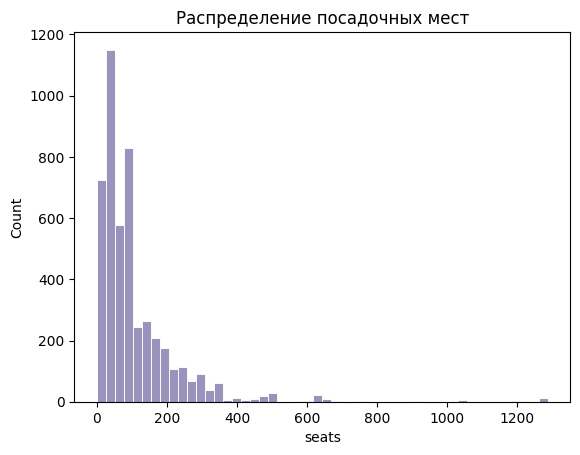

In [19]:
plt.title('Распределение посадочных мест')
sns.histplot(data=df, x='seats', bins=50, color = '#786fa6', edgecolor='white');

Распределение посадочных мест имеет выбросы в виде значений более 500, также есть места с 0 значением посадочных мест, это может быть различные кофейни, забегаловки быстрого питания и места, где количество посадочных мест забыли указать по какой либо причине. 

In [20]:
values=df['category'].value_counts() # список представленных заведений
values

category
кафе               2378
ресторан           2043
кофейня            1413
бар,паб             765
пиццерия            633
быстрое питание     603
столовая            315
булочная            256
Name: count, dtype: int64

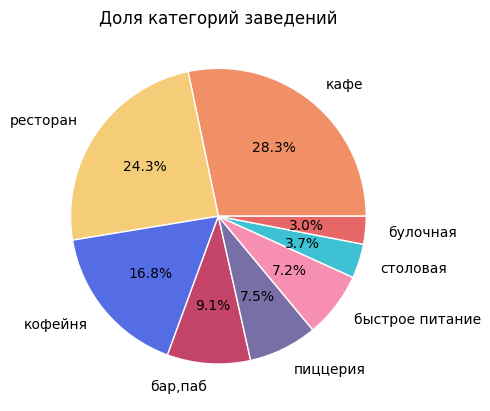

In [21]:
plt.pie(values)  # строю график разделения по категориям
plt.title('Доля категорий заведений')
colors = ['#f19066', '#f5cd79', '#546de5', '#c44569', '#786fa6', '#f78fb3', '#3dc1d3', '#e66767']

plt.pie(values, labels=values.index, autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=colors);

plt.show();

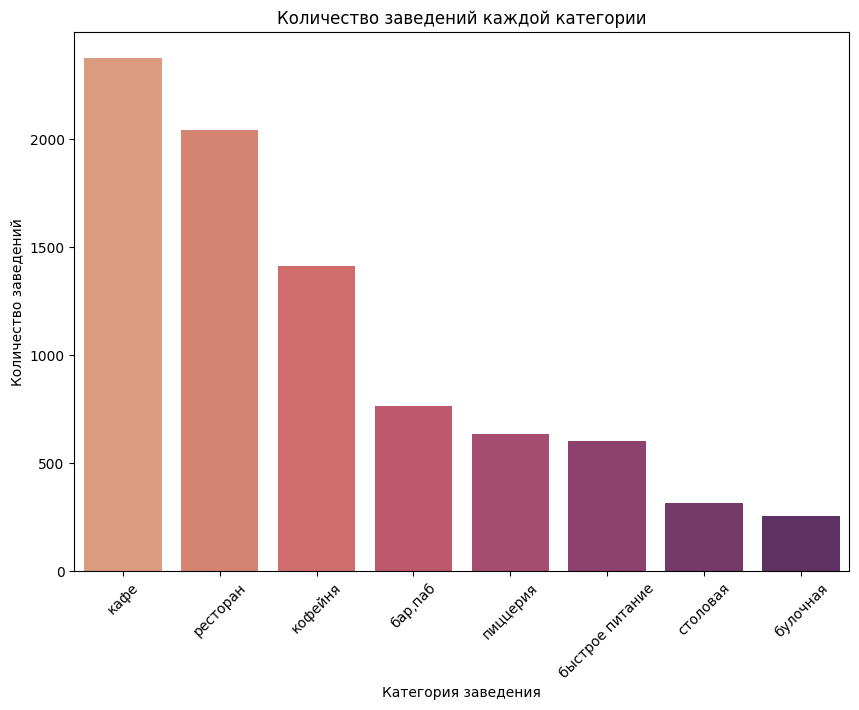

In [22]:
#задаю размер графика
plt.figure(figsize=(10, 7))
plt.title('Количество заведений каждой категории')

sns.barplot(
    x=values.index, 
    y=values, 
    data=values.reset_index(),  
    palette="flare")
plt.ylabel('Количество заведений')
plt.xlabel('Категория заведения')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45);

В представленном датасете представлены по большей части кафе, рестораны и кофейни. 

## Распределение посадочных мест в заведениях

In [23]:
categ = df.groupby('category').agg({'seats':'median'}).reset_index().sort_values('seats', ascending=False)
categ

,category,seats
6,ресторан,86.0
0,"бар,паб",82.5
4,кофейня,80.0
7,столовая,75.5
2,быстрое питание,65.0
3,кафе,60.0
5,пиццерия,55.0
1,булочная,50.0


In [24]:
df['seats'].isna().sum()  # количество пропущенных значений

3611

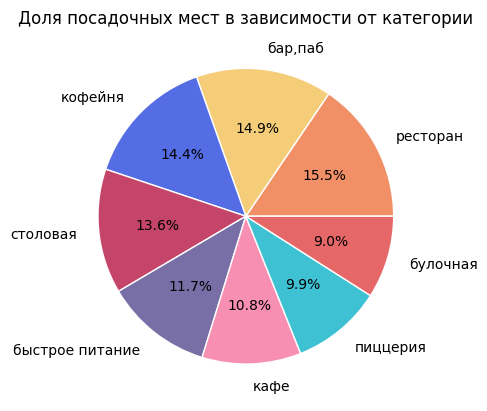

In [25]:
plt.pie(categ['seats'])  # строю график распределения посадочных мест по категориям
plt.title('Доля посадочных мест в зависимости от категории')
colors = ['#f19066', '#f5cd79', '#546de5', '#c44569', '#786fa6', '#f78fb3', '#3dc1d3', '#e66767']

plt.pie(categ['seats'], labels=categ['category'], 
        autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=colors);
plt.show();

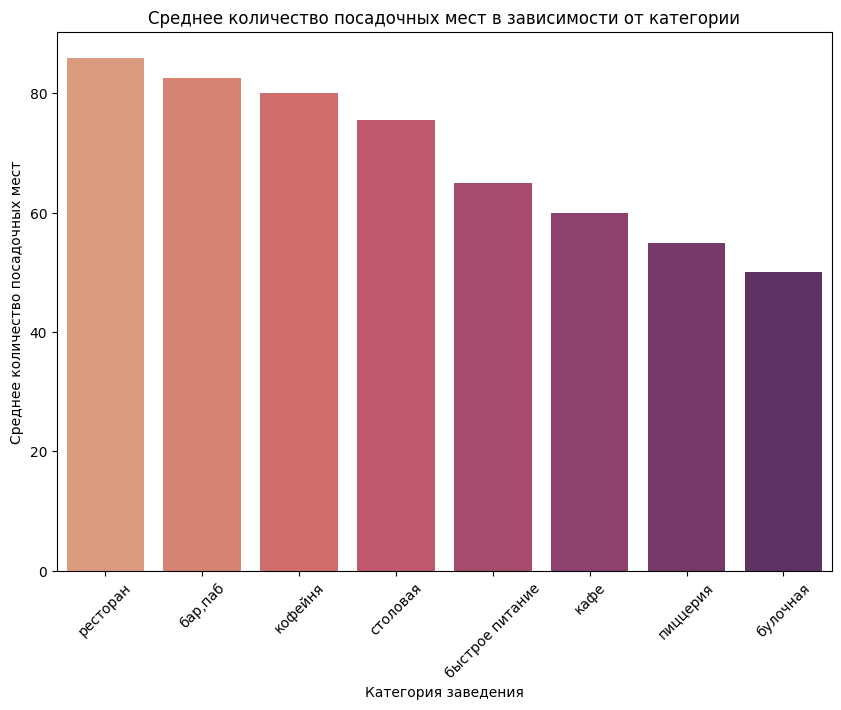

In [26]:
#задаю размер графика
plt.figure(figsize=(10, 7))
plt.title('Среднее количество посадочных мест в зависимости от категории')

sns.barplot(
    x=categ['category'], 
    y=categ['seats'], 
    data=categ,  
    palette="flare")
plt.ylabel('Среднее количество посадочных мест')
plt.xlabel('Категория заведения')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45);

По количеству посадочных мест лидируют рестораны, бары и кофейни, что вплоне закономерно. 

## Соотношение сетевых и несетевых заведений

In [27]:
chain = df['chain'].value_counts().reset_index()
chain

,chain,count
0,не сеть,5201
1,сеть,3205


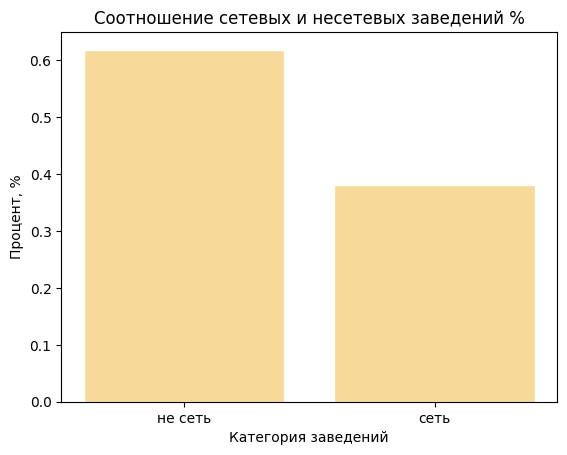

In [28]:
sns.histplot(x=df['chain'], bins=2, stat='probability', discrete=True, shrink=0.8, color='#f5cd79', edgecolor='white')
plt.title('Соотношение сетевых и несетевых заведений %')
plt.xlabel('Категория заведений')
plt.ylabel('Процент, %')
plt.show()

Несетевых заведений в представленном датасете 60% в сравнении с сетевыми, которых 40%. 

In [29]:
# считаю число заведений в каждой категории
df_cat_cnt = df.groupby('category').agg({'name':'nunique'}).reset_index().rename(columns={'name':'cnt_pl'})
df_cat_cnt

,category,cnt_pl
0,"бар,паб",679
1,булочная,138
2,быстрое питание,442
3,кафе,1741
4,кофейня,825
5,пиццерия,361
6,ресторан,1537
7,столовая,242


In [30]:
# считаю число сетевых заведений в каждой категории
df_chain_cnt = (df.query('chain == "сеть"')
                .groupby('category')
                .agg({'name':'nunique'})
                .reset_index().rename(columns={'name':'cnt_ch'})
               )
df_chain_cnt

,category,cnt_ch
0,"бар,паб",88
1,булочная,41
2,быстрое питание,118
3,кафе,353
4,кофейня,157
5,пиццерия,64
6,ресторан,274
7,столовая,53


In [31]:
# определяю долю сетевых заведений в каждой категории
df_ratio = df_cat_cnt.merge(df_chain_cnt, on='category', how='left')
df_ratio['ratio'] = round(df_ratio['cnt_ch'] / df_ratio['cnt_pl'] * 100, 2)
df_ratio

,category,cnt_pl,cnt_ch,ratio
0,"бар,паб",679,88,12.96
1,булочная,138,41,29.71
2,быстрое питание,442,118,26.70
3,кафе,1741,353,20.28
4,кофейня,825,157,19.03
5,пиццерия,361,64,17.73
6,ресторан,1537,274,17.83
7,столовая,242,53,21.90


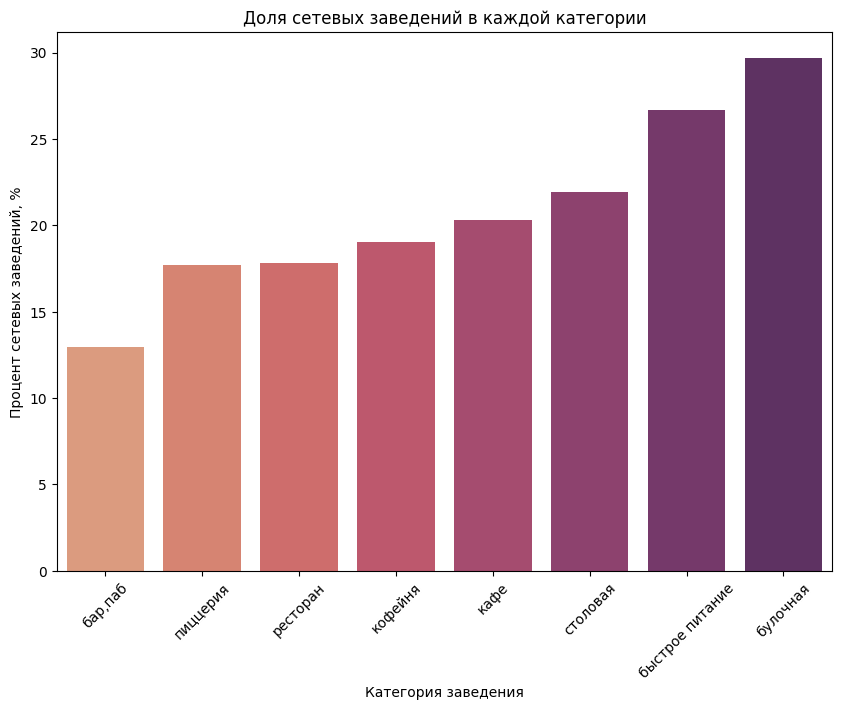

In [32]:
# Set the figure size
plt.figure(figsize=(10, 7))
plt.title('Доля сетевых заведений в каждой категории')

# plot a bar chart
sns.barplot(
    x="category", 
    y="ratio", 
    data=df_ratio.sort_values('ratio'),  
    palette="flare")
plt.ylabel('Процент сетевых заведений, %')
plt.xlabel('Категория заведения')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45);

Среди представленные заведений сетевыми бывают чаще булочные, заведения быстрого питания и столовые.

## Топ 15 сетевых заведений Москвы

In [33]:
top = (df.query('chain == "сеть"')[['name', 'category']]
 .groupby(['name', 'category']).agg({'name':'count'})
 .rename(columns={'name':'cnt'})
 .sort_values('cnt', ascending=False)
).head(15).reset_index()
top

,name,category,cnt
0,шоколадница,кофейня,119
1,домино'с пицца,пиццерия,76
2,додо пицца,пиццерия,74
3,one price coffee,кофейня,71
4,яндекс лавка,ресторан,69
5,cofix,кофейня,65
6,prime,ресторан,49
7,кофепорт,кофейня,42
8,кулинарная лавка братьев караваевых,кафе,39
9,теремок,ресторан,36


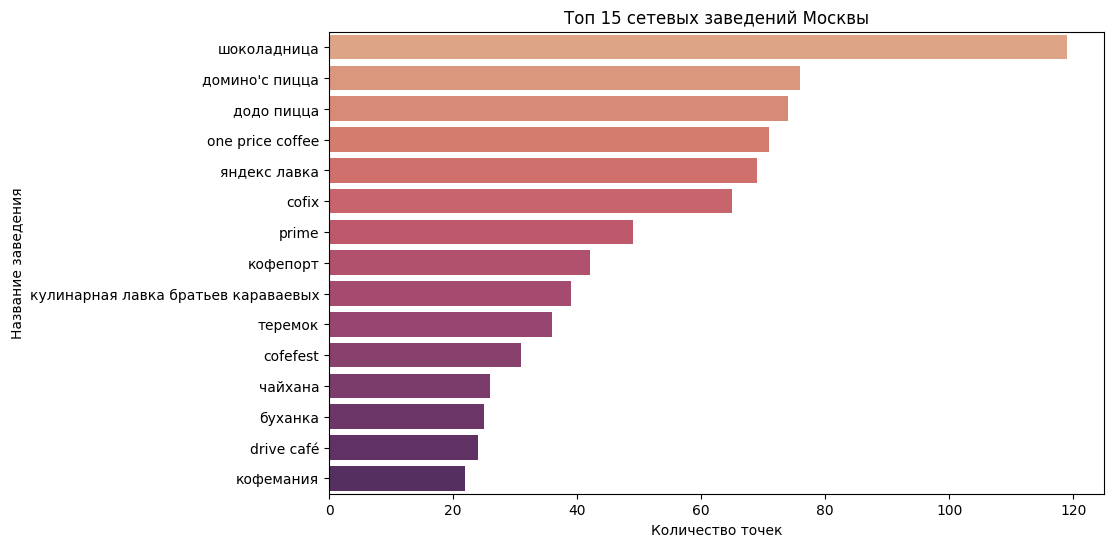

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(y=top['name'], x=top['cnt'],  palette="flare")

plt.title('Топ 15 сетевых заведений Москвы')
plt.ylabel('Название заведения')
plt.xlabel('Количество точек')

# отображаем график на экране
plt.show()

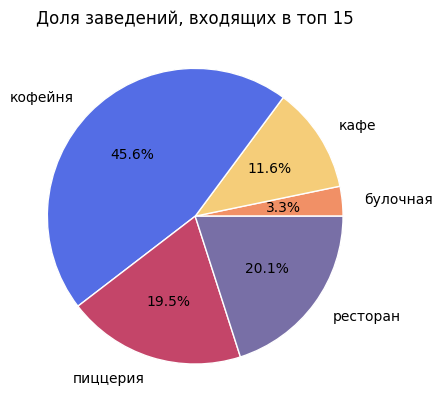

In [35]:
top_categ = top.groupby('category').agg({'cnt':'sum'}).reset_index()
plt.title('Доля заведений, входящих в топ 15')

plt.pie(top_categ['cnt'])  # строю график разделения по категориям
colors = ['#f19066', '#f5cd79', '#546de5', '#c44569', '#786fa6', '#f78fb3', '#3dc1d3', '#e66767']

plt.pie(top_categ['cnt'], 
        labels=top_categ['category'], 
        autopct='%1.1f%%', 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
        labeldistance=1.15, colors=colors);
plt.show();

В топ 15  Москвы попали достаточно известные заведения, такие как Шоколадница, Доминос пицца, Додо пицца, яндекс Лавка и т.д.  Преимущественно в топ заведений входят кофейни 45%, чуть меньше занимают рестораны и пиццерии (около 20%). 

## Административные районы Москвы

In [36]:
df['district'].unique()

array(['Северный административный округ',
       'Северо-Восточный административный округ',
       'Северо-Западный административный округ',
       'Западный административный округ',
       'Центральный административный округ',
       'Восточный административный округ',
       'Юго-Восточный административный округ',
       'Южный административный округ',
       'Юго-Западный административный округ'], dtype=object)

In [37]:
distr_cat = (df.groupby(['district', 'category'])
             .agg({'name':'count'}).reset_index()
             .sort_values(['district','name'], ascending=False)
            ).rename(columns={'name':'cnt'})
distr_cat

,district,category,cnt
67,Южный административный округ,кафе,264
70,Южный административный округ,ресторан,202
68,Южный административный округ,кофейня,131
66,Южный административный округ,быстрое питание,85
69,Южный административный округ,пиццерия,73
...,...,...,...
5,Восточный административный округ,пиццерия,72
2,Восточный административный округ,быстрое питание,71
0,Восточный административный округ,"бар,паб",53
7,Восточный административный округ,столовая,40


In [38]:
distr_categ = (df.pivot_table(index='district', columns='category', values='name', aggfunc='count')
               .sort_values('кафе', ascending=False)
              )
distr_categ

category,"бар,паб",булочная,быстрое питание,кафе,кофейня,пиццерия,ресторан,столовая
district,,,,,,,,
Центральный административный округ,364,50,87,464,428,113,670,66
Юго-Восточный административный округ,38,13,67,282,89,55,145,25
Восточный административный округ,53,25,71,272,105,72,160,40
Северо-Восточный административный округ,63,28,82,269,159,68,182,40
Южный административный округ,68,25,85,264,131,73,202,44
Западный административный округ,50,37,62,239,150,71,218,24
Юго-Западный административный округ,38,27,61,238,96,64,168,17
Северный административный округ,68,39,58,235,193,77,189,41
Северо-Западный административный округ,23,12,30,115,62,40,109,18


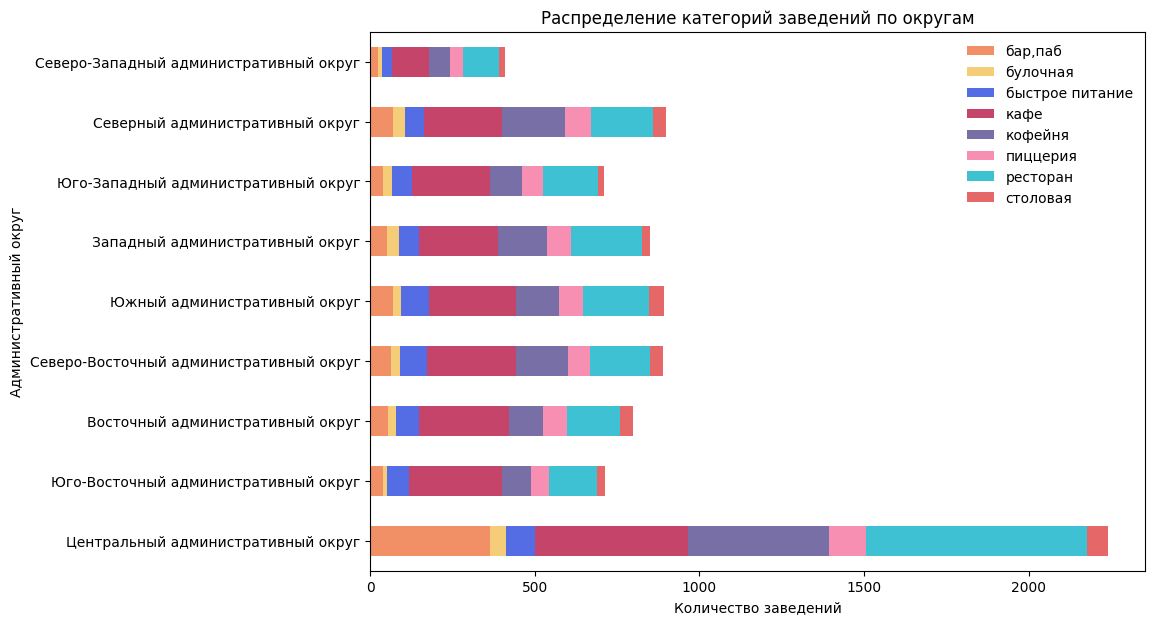

In [39]:
colors = ['#f19066', '#f5cd79', '#546de5', '#c44569', '#786fa6', '#f78fb3', '#3dc1d3', '#e66767']
distr_categ.plot.barh(align='center', stacked=True, figsize=(10, 7), color=colors)   
plt.title("Распределение категорий заведений по округам")
plt.xlabel('Количество заведений')
plt.ylabel('Административный округ')
# уберу рамки в легенде
legend = plt.legend(frameon=False);

По распределению в различных округах Москвы наибольшее количество заведений определяется в Центральном округе, по категориям лидируют рестораны, кафе и кофейни. 

## Распределение рейтингов по категориям

In [40]:
rating_cat = (df.groupby('category')
             .agg({'rating':'mean'}).reset_index()
            .sort_values('rating', ascending=False)
            )
rating_cat

,category,rating
0,"бар,паб",4.387712
5,пиццерия,4.301264
6,ресторан,4.290357
4,кофейня,4.277282
1,булочная,4.268359
7,столовая,4.211429
3,кафе,4.123886
2,быстрое питание,4.050249


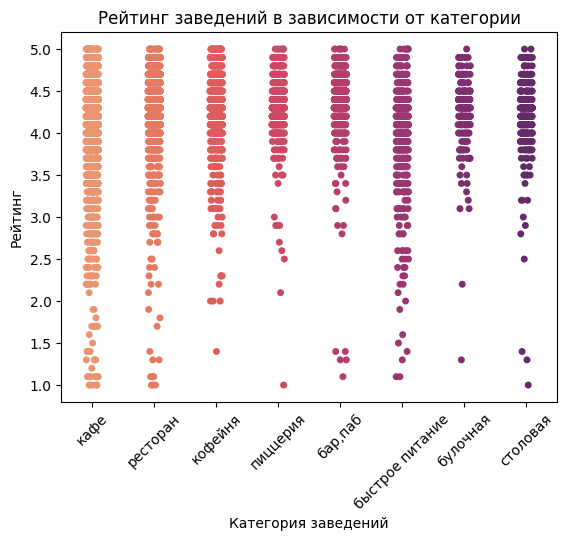

In [41]:
sns.stripplot(x='category', y='rating', data=df, palette="flare") #строю графики распределения по категориям 
plt.title('Рейтинг заведений в зависимости от категории')
plt.xlabel('Категория заведений')
plt.ylabel('Рейтинг')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)
# отображаем график на экране
plt.show()

В зависимости от категории рейтинги заведений отличаются, большее количество высоких оценок имеют пиццерии, бары и булочные. Наибольший разброс в рейтинге у более бюджетных заведений быстрого питания, где видимо не так рвутся за качеством, так же у ресторанов, куда ходят обеспеченные и часто более придирчивые люди, которые ставят не всегда высокие оценки, от ресторанов ожидания чаще высокие. В категорию кафе входит большое количество различных заведений, отсюда и разброс в средней оценке. 

## Средний рейтинг заведений в каждом регионе

In [42]:
rating_df = df.groupby('district', as_index=False)['rating'].agg('median')
rating_df

,district,rating
0,Восточный административный округ,4.3
1,Западный административный округ,4.3
2,Северный административный округ,4.3
3,Северо-Восточный административный округ,4.2
4,Северо-Западный административный округ,4.3
5,Центральный административный округ,4.4
6,Юго-Восточный административный округ,4.2
7,Юго-Западный административный округ,4.3
8,Южный административный округ,4.3


В центральном районе Москвы заведения более высокого качества и имеют рейтинг выше 4,37. А в Северо-Восточном и Южно-Восточном округах рейтинг заведений ниже (4.2)

## Топ 15 улиц по количеству заведений

In [45]:
# группирую по количеству заведений на улицах и выделяю топ 15
top_street = (df.groupby('street')
              .agg(count_object=('name', 'count'))
              .reset_index().sort_values('count_object', ascending=False).head(15)
             )
list_top_street = top_street['street']
list_top_street

837              проспект мира
841          профсоюзная улица
834       проспект вернадского
533         ленинский проспект
531     ленинградский проспект
379          дмитровское шоссе
461            каширское шоссе
304           варшавское шоссе
532        ленинградское шоссе
610                       мкад
555           люблинская улица
1076            улица вавилова
523       кутузовский проспект
1231      улица миклухо-маклая
849            пятницкая улица
Name: street, dtype: object

In [46]:
df_top_street = (df.query('street in @list_top_street')
                 .pivot_table(index=['street','category'], values='name', aggfunc='count')
                .reset_index()
                ).rename(columns={'name':'count_object'}).sort_values(['street', 'count_object'], ascending=False)
                 
df_top_street.head()

,street,category,count_object
107,улица миклухо-маклая,кафе,21
110,улица миклухо-маклая,ресторан,15
106,улица миклухо-маклая,быстрое питание,4
108,улица миклухо-маклая,кофейня,4
105,улица миклухо-маклая,"бар,паб",3


In [47]:
street_category = (df.query('street in @list_top_street')
                   .pivot_table(index='street', columns='category', values='name', aggfunc='count')
                   )
street_category['all'] = street_category.sum(axis=1)
street_category = street_category.sort_values('all')
street_category

category,"бар,паб",булочная,быстрое питание,кафе,кофейня,пиццерия,ресторан,столовая,all
street,,,,,,,,,
пятницкая улица,9.0,3.0,2.0,7.0,6.0,3.0,18.0,NaN,48.0
улица миклухо-маклая,3.0,NaN,4.0,21.0,4.0,2.0,15.0,NaN,49.0
кутузовский проспект,2.0,1.0,2.0,14.0,13.0,3.0,16.0,3.0,54.0
улица вавилова,2.0,2.0,11.0,15.0,10.0,3.0,12.0,NaN,55.0
люблинская улица,5.0,NaN,5.0,26.0,11.0,1.0,10.0,2.0,60.0
мкад,1.0,NaN,9.0,45.0,4.0,NaN,5.0,1.0,65.0
ленинградское шоссе,5.0,2.0,5.0,13.0,13.0,3.0,26.0,3.0,70.0
варшавское шоссе,6.0,NaN,7.0,18.0,14.0,4.0,20.0,7.0,76.0
каширское шоссе,2.0,NaN,10.0,20.0,16.0,5.0,19.0,5.0,77.0


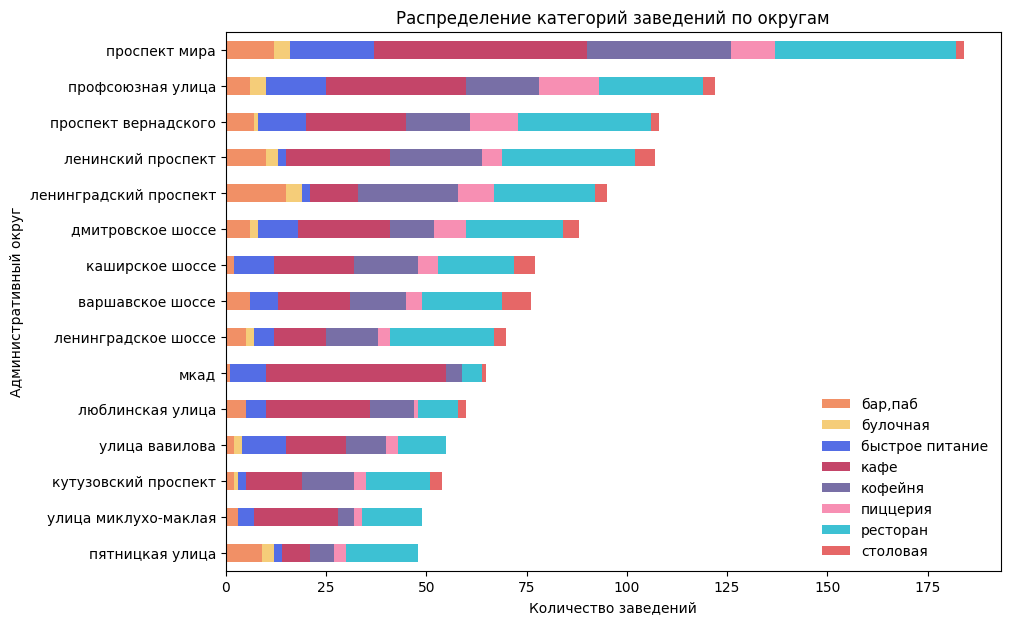

In [48]:
colors = ['#f19066', '#f5cd79', '#546de5', '#c44569', '#786fa6', '#f78fb3', '#3dc1d3', '#e66767']
street_category.iloc[:, 0:8].plot.barh(align='center', stacked=True, figsize=(10, 7), color=colors)   
plt.title("Распределение категорий заведений по округам")
plt.xlabel('Количество заведений')
plt.ylabel('Административный округ')
# уберу рамки в легенде
legend = plt.legend(frameon=False);

Среди топа 15 улиц по количеству заведений встречаются в основном центральные улицы Москвы (пр. Мира, Профсоюзная улица, Ленинский пр-кт). Распределение заведений по ним схоже: в топе заведений кафе, рестораны и кофейни. Рестораны и кофейни распространены преимущественно в центре, кафе же есть и немного удаленнее от центра (округ МКАД). 

## Улицы с одним объектом общепита

In [49]:
# группирую по количеству объектов на улицах 
df_cnt_street = (df.groupby(['category', 'street', 'chain'])
 .agg(count_object=('name', 'count'))
 .reset_index().sort_values('count_object', ascending=False)
                 .query('count_object == 1')
                 .groupby(['category', 'chain']).agg('count')
                ).reset_index()

df_cnt_street

,category,chain,street,count_object
0,"бар,паб",не сеть,262,262
1,"бар,паб",сеть,113,113
2,булочная,не сеть,89,89
3,булочная,сеть,116,116
4,быстрое питание,не сеть,155,155
5,быстрое питание,сеть,124,124
6,кафе,не сеть,405,405
7,кафе,сеть,270,270
8,кофейня,не сеть,302,302
9,кофейня,сеть,226,226


В датасете присутствуют улицы с одним заведением общепита на улице, вероятнее, в спальных районах Москвы. По распределению видно, что чаще этими заведенями являются несетевые кафе, рестораны и кофейни. 

## Средний чек 


In [50]:
df['middle_avg_bill'].describe()

count     3149.000000
mean       958.053668
std       1009.732845
min          0.000000
25%        375.000000
50%        750.000000
75%       1250.000000
max      35000.000000
Name: middle_avg_bill, dtype: float64

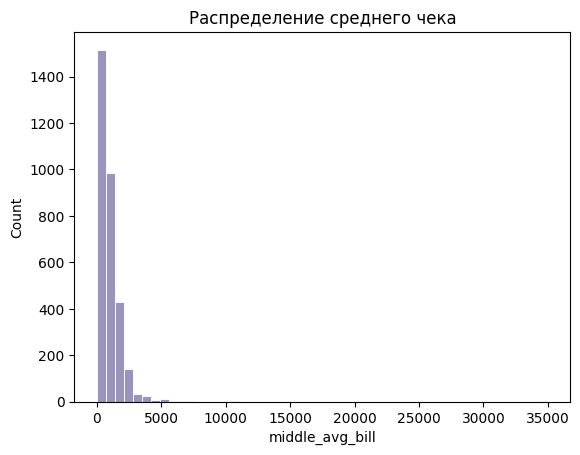

In [51]:
plt.title('Распределение среднего чека')
sns.histplot(data=df, x='middle_avg_bill', bins=50, color = '#786fa6', edgecolor='white');

В данных по среднему чеку явно присутствуют выбросы, поэтому далее будем использовать медианные значения, чтобы минимизировать влияние выбросов

In [52]:
# группирую данные по районам и расчитываю средний чек в каждом
median_bill = (df.groupby('district')
 .agg({'middle_avg_bill':'median'})
 .reset_index().sort_values('middle_avg_bill', ascending=False)
)

median_bill

,district,middle_avg_bill
1,Западный административный округ,1000.0
5,Центральный административный округ,1000.0
4,Северо-Западный административный округ,700.0
2,Северный административный округ,650.0
7,Юго-Западный административный округ,600.0
0,Восточный административный округ,575.0
3,Северо-Восточный административный округ,500.0
8,Южный административный округ,500.0
6,Юго-Восточный административный округ,450.0


- По карте видны наиболее дорогие районы (где средний чек в районе 1000р на человека), это Центральный, Западный и район аэропорта Внуково. Западный округ считается самым престижным в Москве, там большое количество университетов и самый экологически чистый воздух.  Видимо данных о заведениях других аэропортов не попали в датасет, там ценник всегда повышен на 20%. 
- Выделяются более бюджетные районы: Юго- и Северо-Восточный и Южный округа, где средний чек в два раза ниже. Там и рейтинг заведений, судя по предыдущему хороплету, ниже. 
- Для того чтобы оценить, как влияет удаленность от центра на средний чек, мне не хватает данных, данные разделенены по АО, в связи с чем заливаются единым цветом, не хватает деления на микрорайоны. 

## Вывод

В датасете представлены различные заведения общественного питания города Москвы. 
- Превалируют кафе, рестораны и кофейни, по количеству посадочных мест - растораны, бары и кофейни. 60% заведений несетевые, 40% - сетевые. 

- В топ 15 заведений Москвы вошли по большей части кофейни разной ценовой категории (такие как Шоколадница, one price coffee, cofix). 

- По количеству заведений преобладает Центральный административный округ, в остальных округах примерно схожее число заведений. 
- Средний рейтинг заведений выше в Центре Москвы, так же как и средний чек, в Центральном и Западном округах Москвы средний чек превышает в два раза остальные районы (около 1000р на человека).

# Открытие кофейни

## Распределение кофеин по округам

In [54]:
df_coff = df.query('category == "кофейня"') # филдьтрую из всех категорий кофейни
len(df_coff['name'].unique())

825

В датасете представлено 825 заведений, где варят кофе

In [55]:
df_coff.shape

(1413, 16)

In [56]:
pd.DataFrame(round(df_coff.isna().mean()*100, 2))

,0
name,0.00
category,0.00
address,0.00
district,0.00
hours,1.06
lat,0.00
lng,0.00
rating,0.00
price,66.31
avg_bill,48.97


В датасете с кофейнями большое количество пропущенных значений в столбцах со средним чеком и ценой за чашку капучино. Заполнять эти пропуски не стоит, потому что я не знаю точные цены в конкретных заведениях, а медианные значения могут исказить реальность. 

In [57]:
# группирую количество кофеин по округам
coff = df_coff.groupby('district').agg({'name':'count'}).reset_index().sort_values('name', ascending = False)
coff

,district,name
5,Центральный административный округ,428
2,Северный административный округ,193
3,Северо-Восточный административный округ,159
1,Западный административный округ,150
8,Южный административный округ,131
0,Восточный административный округ,105
7,Юго-Западный административный округ,96
6,Юго-Восточный административный округ,89
4,Северо-Западный административный округ,62


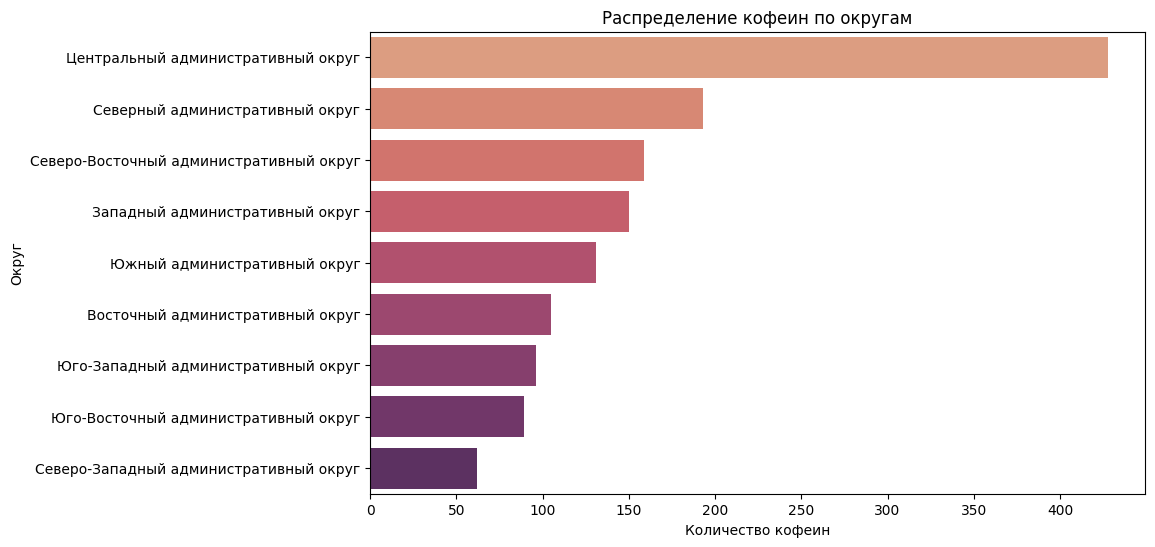

In [58]:
# визуализирую количество кофеин по округам
plt.figure(figsize=(10, 6))
sns.barplot(y=coff['district'], x=coff['name'], palette="flare")

plt.title('Распределение кофеин по округам')
plt.ylabel('Округ')
plt.xlabel('Количество кофеин')

# отображаем график на экране
plt.show()

В датасете представлено 825 кофеин, большинство из которых расположены в Центральном районе. 

In [59]:
# считаю кофейни, которые работают 24/7 и определяю их процент среди общего количества
round(len(df_coff.query('is_247 == 1')) / len(df_coff['name'].unique()) * 100, 2)

7.15

In [60]:
# группирую круглосуточно работающие кофейни по округам
df_coff_24 = (df_coff.query('is_247 == 1')
 .groupby('district').agg({'name':'count'}).reset_index()
 .sort_values('name', ascending = False)
)
df_coff_24 

,district,name
5,Центральный административный округ,26
1,Западный административный округ,9
7,Юго-Западный административный округ,7
0,Восточный административный округ,5
2,Северный административный округ,5
3,Северо-Восточный административный округ,3
4,Северо-Западный административный округ,2
6,Юго-Восточный административный округ,1
8,Южный административный округ,1


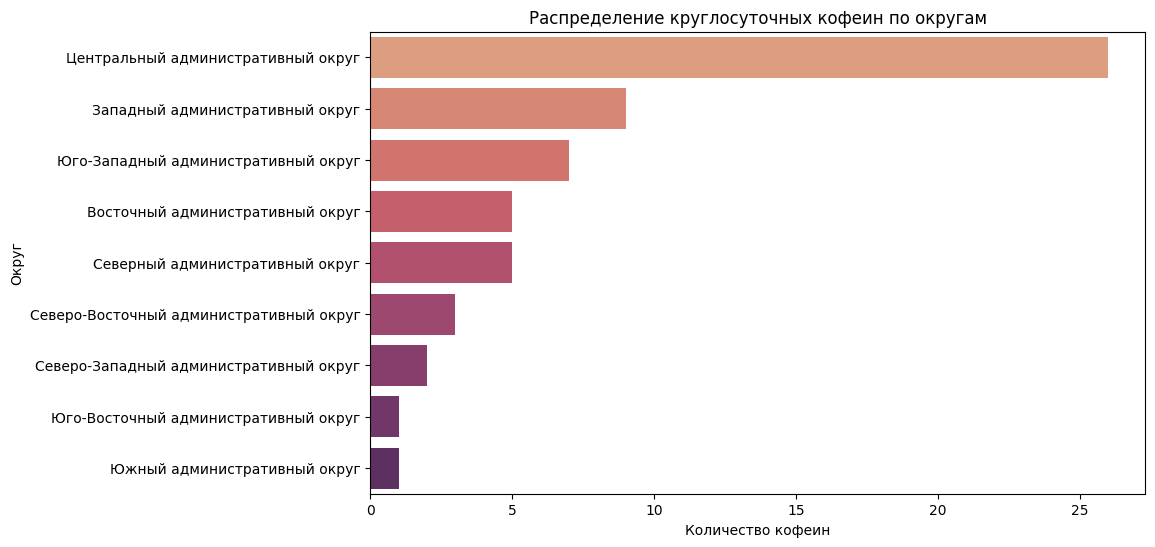

In [61]:
plt.figure(figsize=(10, 6))
sns.barplot(y=df_coff_24 ['district'], x=df_coff_24 ['name'], palette="flare")

plt.title('Распределение круглосуточных кофеин по округам')
plt.ylabel('Округ')
plt.xlabel('Количество кофеин')

# отображаем график на экране
plt.show()

В датасете есть круглосуточные кофейни, но они составляют лиш 7% от общего количества. Большинство круглосуточно работающих кофеин расположены в Центральном районе, где наибольший трафик и соответственно, высокий спрос. Но как мне кажется, кофейни ночью не так актуальны, лучше делать часы работы с 7:30-8, чтобы люди имели возможность перед работой выпить чашечку любимого кофе. 

## Средний рейтинг 

In [62]:
rating_coff = df_coff.groupby('district', as_index=False)['rating'].agg('median')
rating_coff

,district,rating
0,Восточный административный округ,4.3
1,Западный административный округ,4.2
2,Северный административный округ,4.3
3,Северо-Восточный административный округ,4.3
4,Северо-Западный административный округ,4.3
5,Центральный административный округ,4.3
6,Юго-Восточный административный округ,4.3
7,Юго-Западный административный округ,4.3
8,Южный административный округ,4.3


Рейтинги кофеин достаточно однородно распределены по округам, за исключением одних из самых престижных районов Москвы - Западного округа и аэропорта Внукова, возможно потому, что цены на кофе там завышены, что ведет к завышенным ожиданиям, которые не всегда оправдываются.

## Средний чек за чашку капучино

In [64]:
df_coff['middle_coffee_cup'].describe()

count     521.000000
mean      175.055662
std        89.753009
min        60.000000
25%       124.000000
50%       170.000000
75%       225.000000
max      1568.000000
Name: middle_coffee_cup, dtype: float64

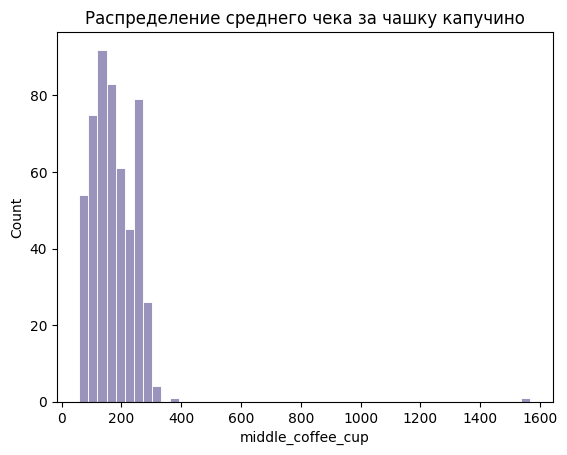

In [65]:
plt.title('Распределение среднего чека за чашку капучино')
sns.histplot(data=df_coff, x='middle_coffee_cup', bins=50, color = '#786fa6', edgecolor='white');

In [66]:
df_coff.query('middle_coffee_cup > 800')

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,street,is_247
2859,шоколадница,кофейня,"москва, большая семеновская улица, 27, корп. 1",Восточный административный округ,"ежедневно, 08:00–23:00",55.782268,37.709022,4.2,средние,Цена чашки капучино:230–2907 ₽,NaN,1568.0,сеть,48.0,большая семеновская улица,0


По распределению цен встречаются выбросы в виде цены за чашку до 2907р в Шоколаднице, поэтому далее использую медианные значения средней цены, чтобы избежать их влияния. 

In [67]:
# группирую данные по районам и расчитываю средний чек в каждом
median_coff = (df_coff.groupby('district')
 .agg({'middle_coffee_cup':'median'})
 .reset_index().sort_values('middle_coffee_cup', ascending=False)
)

median_coff

,district,middle_coffee_cup
7,Юго-Западный административный округ,198.0
5,Центральный административный округ,190.0
1,Западный административный округ,189.0
4,Северо-Западный административный округ,165.0
3,Северо-Восточный административный округ,162.5
2,Северный административный округ,159.0
8,Южный административный округ,150.0
6,Юго-Восточный административный округ,147.5
0,Восточный административный округ,135.0


Цены за чашку капучино примерно соответствуют ценам в кафе, более высокие цены (более 190р) в дорогих и престижных районах Москвы - центр, Западный округ и аэропорт Внуково, где цены на аренду помещений выше. В Восточном округе цены значительно ниже (135р за чашку капучино). 

При открытии кофейни стоит руководствоваться выбором округа и средних цен за кофе в этом округе. Желательно присмотреться к наиболее проходимым местам в центре Москвы. При рассмотрении кофеин на карте можно найти место, где нет их большого скопления. Цену за чашку капучино я бы рекомендовала ставить в районе 180-190 рублей, не ниже, чем медианный показатель цены в центральном округе Москвы. И сделать упор на качестве кофе, стильном интерьере кафе, обслуживании. 

## Влияние категории кофейни на рейтинг 

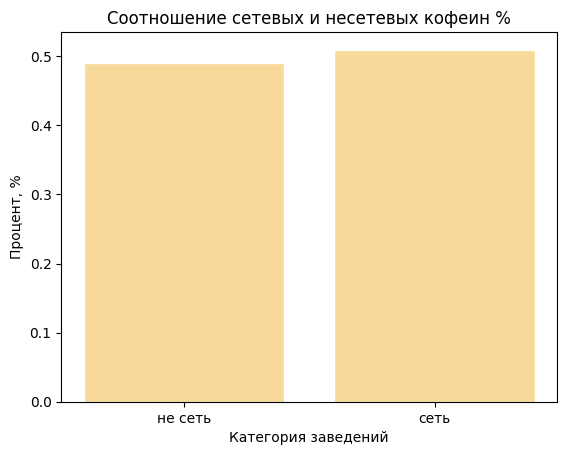

In [70]:
sns.histplot(x=df_coff['chain'], bins=2, stat='probability', discrete=True, shrink=0.8, color='#f5cd79', edgecolor='white')
plt.title('Соотношение сетевых и несетевых кофеин %')
plt.xlabel('Категория заведений')
plt.ylabel('Процент, %')
plt.show()

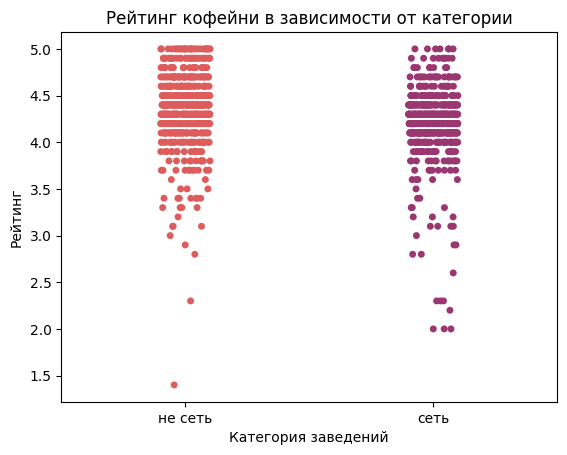

In [71]:
#строю графики распределения на сетевые и несетевые кофейни
sns.stripplot(x='chain', y='rating', data=df_coff, palette="flare") 
plt.title('Рейтинг кофейни в зависимости от категории')
plt.xlabel('Категория заведений')
plt.ylabel('Рейтинг')

# отображаем график на экране
plt.show()

В датасете представлено примерно одинаковое соотношение сетевых и несетевых кофеин (сетевых больше на 2 проц. пункта). На распределение рейтинга категория кофейни достоверно не влияет, рейтинг несетевых кофеин судя по графику распределения несущественно выше, чем сетевых. 

## Вывод 

БОльшая часть кофеин расположены в Центральном районе Москвы, лишь 7% из них работают круглосуточно. 
- Средний рейтинг кофеин достаточно высокий (выше 4.3) во всех округах Москвы, за исключением престижных районов (Запад и аэропорт Внуково), где рейтинг немного ниже 4.2, что может быть связано с высокими ценами, которые ведут к завышеным ожиданиям, также завышенные требования от клиентов. 
- Средний чек за чашку капучино выше в Центре, на Западе Москвы и в аэропорте Внуково (более 190 руб), что вполне обосновано более высокой ценой аренды помещения. (Данных с других аэропортов Москвы нет в изучаемом датасете). 
- При разбивке кофеин на категории, сетевых заведений немногим больше, чем несетевых (на 2 проц. пункта). На распределение рейтинга категория кофейни значимо не влияет.


# Основной вывод

Было проведено исследование датасета с заведениями общественного питания Москвы за лето 2022г, изучалось влияние локализации заведения на средний чек и рейтинг. Более детально изучались кофейни.

- Рейтинг заведений различается в зависимости от локализации среди всех заведений - максимальный рейтинг в Центре Москвы, среди кофеин - рейтинг высокий во всех округах за исключением ЗАО и аэропортов. 
- Средние цены также различаются - более высокие в престижных районах Москвы (ЦАО и ЗАО). 

- Для ответа на вопрос про открытие кофейни мне не хватает данных о трафике в различных районах Москвы, чтобы расчитать примерную прибыль в заведениях. По имеющимся данным можно сделать вывод о том, что кофейни входят в ТОП 15 заведений Москвы и составляют 46% от общего количества заведений. Я бы советовала открывать кофейню в Центральном районе Москвы, где высокий рейтинг заведений и высокая цена за чашку капучино. Можно предположить, что трафик в центре Москвы достаточно высокий, чтобы быстро окупить затраты и начать получать прибыль. Но необходимо тщательно продумать концепт заведения, чтобы людям захотелось заходить и возвращаться в это заведение, интерьер, качество кофе, отличное обслуживание и т.д., так как конкуренция будет очень высокой.
- Ориентироваться по ценам стоит в зависимости от локализации и выставлять не ниже, чем средние цены в аналогичном округе Москвы: в ЦАО это 180-190 руб за чашку капучино, чуть ниже цены в САО (160-170 руб.), в ЮАО (145-155 руб.) и самые низкие в ВАО (135-145 руб.)

Ссылка на презентацию: https://disk.yandex.ru/i/q6gdHDtuP5f0OA